In [68]:
from datetime import datetime
import warnings
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from math import sqrt
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split, KFold 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb
from lightgbm import LGBMRegressor
from bayes_opt import BayesianOptimization

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

#### 1. Load Data

In [2]:
train = pd.read_csv("../data/train.csv") 
train.datetime = pd.to_datetime(train.datetime)
train['hr'] = train.datetime.dt.hour
train['mnth'] = train.datetime.dt.month
# Remove unnecessary columns
train.drop(['casual', 'registered'], axis = 1, inplace = True)
train.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hr,mnth
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,1
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,1


#### 2. EDA
- Create extra features (day of week)
- Check feature distributions
- Check target variable distribution
- Check correlation(s)

    - Determine days of week for new feature 'weekday': Sat(0) -> Fri(6) 

In [3]:
df_day = train.copy()
df_day["Day"] = df_day.datetime.dt.date
df_day.drop_duplicates(subset = ['Day'], inplace = True)
df_day.reset_index(drop = True, inplace = True)
df_day['weekday'] = df_day.index.values%7
df_day = df_day[['Day', 'weekday']]
train['Day_'] = train.datetime.dt.date
# Merge weekday with train
train = train.merge(df_day, left_on='Day_', right_on='Day').drop(["Day", 'Day_'], axis = 1)
# Move count to end:
cols = list(train)
cols.insert(len(cols)-1, cols.pop(cols.index('count')))
train = train[cols]
print(train.weekday.value_counts())
train.head(2)

0    1580
2    1555
4    1554
1    1553
5    1552
6    1551
3    1541
Name: weekday, dtype: int64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hr,mnth,weekday,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,0,1,0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,1,1,0,40


##### Feature Distributions
- How many years of data?

In [290]:
train.datetime.dt.year.value_counts()

2012    5464
2011    5422
Name: datetime, dtype: int64

- Check spread of count across various categorical features:

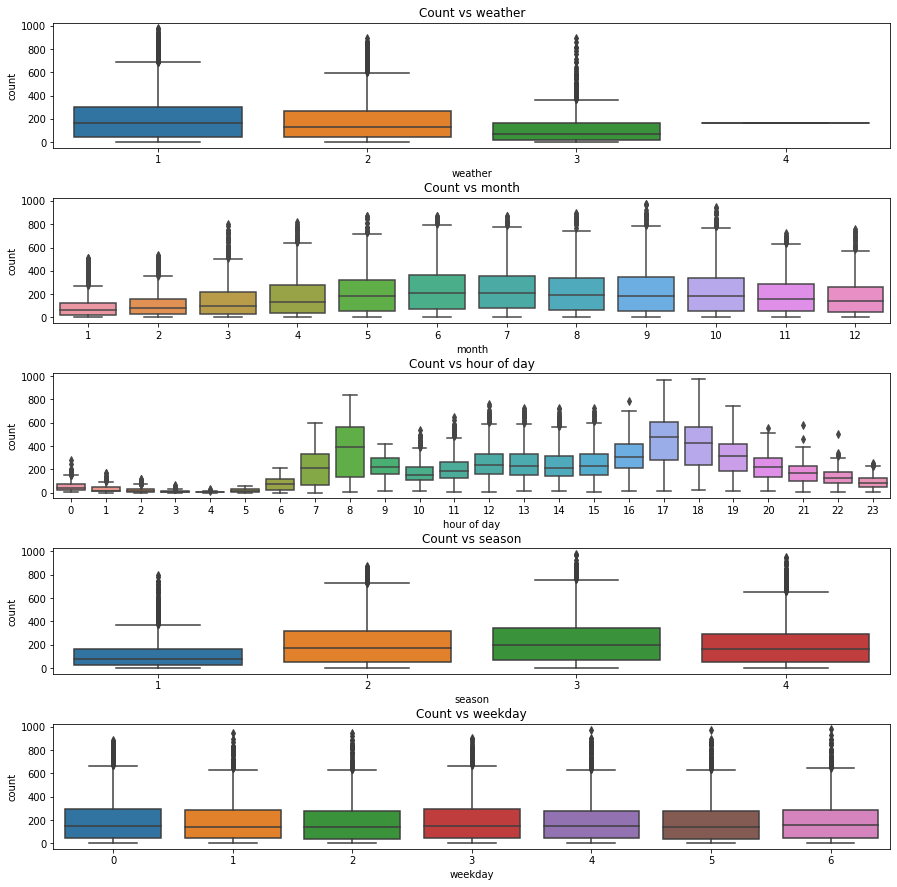

In [291]:
features = ['weather', 'mnth', 'hr', 'season', 'weekday']
x_axis_titles = ['weather', 'month', 'hour of day', 'season', 'weekday']
f, axs = plt.subplots(len(features), 1, figsize=(15,3*len(features)))

for i in range(len(features)):
    sns.boxplot(data=train,y="count",x=features[i],orient="v",ax=axs[i])
    axs[i].set(xlabel=x_axis_titles[i], ylabel='count',title='Count vs ' + x_axis_titles[i])

plt.subplots_adjust(left=None, bottom=None, right=None, top=0.89, wspace=None, hspace=0.4)

- *Weekday* looks irrelevant
- Other potential features appear to capture variance 

- Check count dependence on numerical features

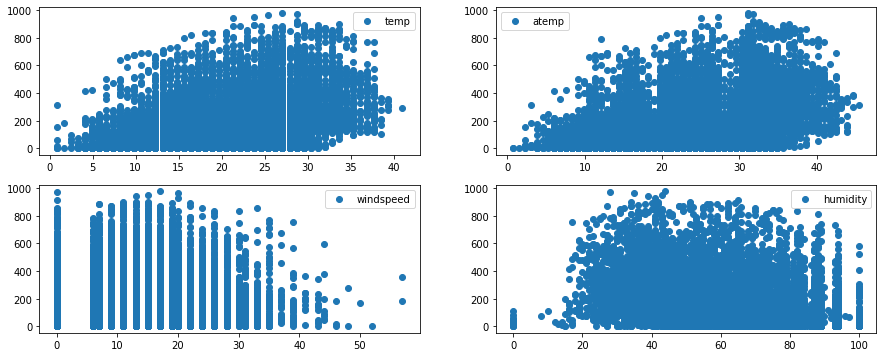

In [292]:
features = ['temp', 'atemp', 'windspeed', 'humidity']
f, axs = plt.subplots(2, 2, figsize=(15,6))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.scatter(train[features[i]], train['count'], label = features[i])
    ax.legend()

- atemp looks highly correllated with temp
- potentially missing values for windspeed? defaulted to 0?
- humidity may also be too correlated with temp
- humidity appears to have missing values between 0 and ~ 10

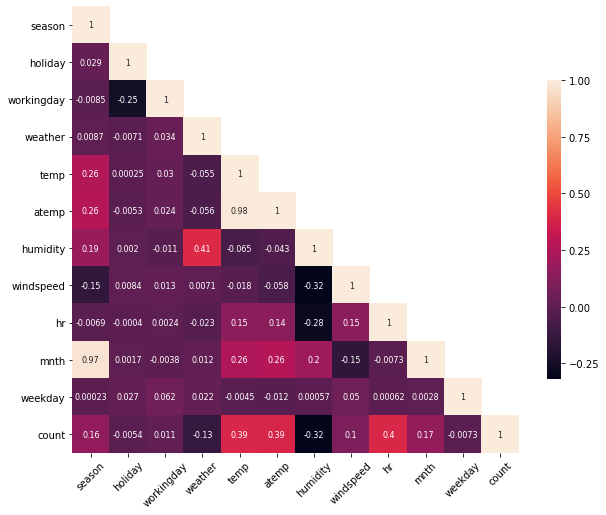

In [293]:
cor_mat= train[2:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig = plt.gcf()
fig.set_size_inches(10,11)
ax = sns.heatmap(data=cor_mat,mask=mask,square=True,cbar_kws={"shrink": .5}, annot=True,cbar=True, annot_kws={"fontsize":8})
ylim_lower = (ax.get_ylim()[0] + 0.5)
ylim_upper = (ax.get_ylim()[1] - 0.5)
ax.set_ylim(ylim_lower, ylim_upper)
plt.xticks(rotation=45) 
_ = plt.yticks(rotation=0) 

**Observations**
    - 'mnth' & 'season' appear highly correlated (multicollinearity risk)
        - Perhaps drop season and keep mnth given mnth appears slightly better correlated with 'count'
        - For algorithms sensitive to multicollinearity dropping the variable would be sensible
    - 'weekday', 'holiday' & 'workingday' have clearly little correlation with count and can definitely be dropped
    - 'atemp' is highly correlated with 'temp' and can be dropped (has also same correlation coefficient with 'count')
    - 'windspeed' needs to be further investigated: 
    - 'humidity' appears considerably correlated with weather.. may need further assessment 

In [4]:
# New dataframe:
#train.drop(['weekday', 'holiday', 'atemp', 'datetime'], axis = 1, inplace = True)
train.drop(['datetime'], axis = 1, inplace = True)
train.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hr,mnth,weekday,count
0,1,0,0,1,9.84,14.395,81,0.0,0,1,0,16
1,1,0,0,1,9.02,13.635,80,0.0,1,1,0,40


- replace '0' values in windspeed with random integer values between minimum recorded windspeed (= 6.0032) and zero 

New Pearson correlation coefficient =  0.1


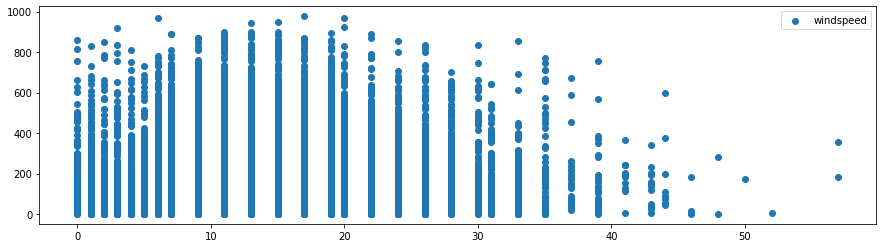

In [5]:
#mu = train[train.windspeed != 0].windspeed.values.mean()
#sigma = train[train.windspeed != 0].windspeed.values.std()
#num_zeros = len(train[train.windspeed == 0])
#train[train.windspeed == 0].windspeed = np.random.normal(mu, sigma, num_zeros)
#train.loc[train['windspeed'] == 0,'windspeed'] = train['windspeed'].apply(lambda x: int(round((np.random.uniform(0, train[train.windspeed != 0].windspeed.values.min(), 1)[0]))))
#train.loc[train['windspeed'] < 0,'windspeed'] = 0
train.loc[train['windspeed'] == 0,'windspeed'] = (np.round(np.random.uniform(0,train[train.windspeed != 0].windspeed.values.min(), len(train.loc[train['windspeed'] == 0]))))

f, axs = plt.subplots(1, 1, figsize=(15,4))
axs.scatter(train['windspeed'], train['count'], label = 'windspeed')
_ = axs.legend()
print("New Pearson correlation coefficient = ", round(stats.pearsonr(train['windspeed'], train['count'])[0], 2))

    - correlation coefficient has remained the same:

- Target variable distribution skewness - has positive skew (tail to right)
    - try taking log of target variable

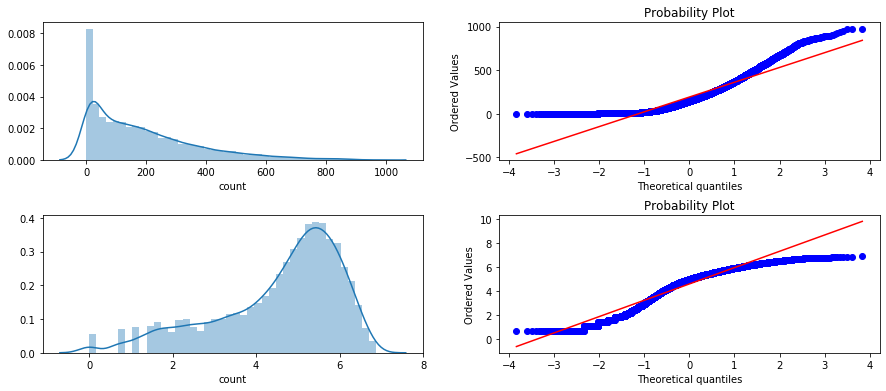

In [6]:
f = plt.figure(figsize=(15,6))
sns.distplot(train["count"],ax=f.add_subplot(221))
res = stats.probplot(train["count"], dist='norm', fit=True, plot=f.add_subplot(222))
sns.distplot(np.log(train["count"]),ax=f.add_subplot(223))
res = stats.probplot(np.log1p(train["count"]), dist='norm', fit=True, plot=f.add_subplot(224))
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.89, wspace=None, hspace=0.4)
train['log_count'] = np.log1p(train['count'])

    - Skewness has improved a little (now indicating negative skew however)

#### Convert some categorical features to one hot encoding 
    - Some machine-learning algorithms may work better this way
    - keep backup of original train df:
        - Some tree-based learners may not do as well with one-hot encoded features (too sparse)

In [7]:
# Sort Weather Categorical Data:
train_old = train.copy()
temp = pd.get_dummies(train['weather'], prefix='weather', drop_first = True)
train = pd.concat([train,temp],axis=1).drop(['weather'], axis = 1)

# Sort Season Categorical Data:
temp = pd.get_dummies(train['season'], prefix='season', drop_first = True)
train = pd.concat([train,temp],axis=1).drop(['season'], axis = 1)

# Sort Hour Categorical Data:
temp = pd.get_dummies(train['hr'],prefix='hr', drop_first = True)
train = pd.concat([train,temp],axis=1).drop(['hr'], axis = 1)

# Sort Month Categorical Data:
temp = pd.get_dummies(train['mnth'],prefix='mnth', drop_first = True)
train = pd.concat([train,temp],axis=1).drop(['mnth'], axis = 1)

cols = list(train)
cols.insert(len(cols)-1, cols.pop(cols.index('count')))
train = train[cols]
cols = list(train)
cols.insert(len(cols)-1, cols.pop(cols.index('log_count')))
train = train[cols]
# Move target variable to end
train.head(2)

,holiday,workingday,temp,atemp,humidity,windspeed,weekday,weather_2,weather_3,weather_4,season_2,season_3,season_4,hr_1,hr_2,hr_3,hr_4,hr_5,hr_6,hr_7,hr_8,hr_9,hr_10,hr_11,hr_12,hr_13,hr_14,hr_15,hr_16,hr_17,hr_18,hr_19,hr_20,hr_21,hr_22,hr_23,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,mnth_7,mnth_8,mnth_9,mnth_10,mnth_11,mnth_12,count,log_count
0,0,0,9.84,14.395,81,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,2.833213
1,0,0,9.02,13.635,80,5.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,40,3.713572


In [8]:
train_old.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hr,mnth,weekday,count,log_count
0,1,0,0,1,9.84,14.395,81,3.0,0,1,0,16,2.833213
1,1,0,0,1,9.02,13.635,80,5.0,1,1,0,40,3.713572


#### Check collinearity of variables with variance inflation factor:
- https://etav.github.io/python/vif_factor_python.html

- https://campus.datacamp.com/courses/generalized-linear-models-in-python/multivariable-logistic-regression?ex=4
    - "Recall from the video that the rule of thumb threshold is VIF at the level of 2.5, meaning if the VIF is above 2.5 you should consider there is effect of multicollinearity on your fitted model."
- https://www.statsmodels.org/stable/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
    - "One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this."

In [9]:
# Check higher variance inflation factors
def checkVarInfFactor(df):
    # For each X, calculate VIF and save in dataframe
    #array = df.values
    #X = array[:,1:(df.shape[1] - 1)]
    #Y = array[:,(df.shape[1] - 1)]
    #X = df.copy()
    df_ = df.drop(['count', 'log_count'], axis=1)
    X = add_constant(df_)

    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Display Features with High Variance Inflation Factor
    corrFeatures = []
    corrFeatures.append("count")
    for i in range(0, len(vif["features"] )):
        if vif["VIF Factor"][i] > 2.5 and vif["features"][i] != "const":
            print("{} = {:.2f}".format(vif["features"][i], vif["VIF Factor"][i]), end = ', ')   
            corrFeatures.append(vif["features"][i])
            
# Check Pearson's correlation coefficient of variables without visualising entire heatmap
def checkPearsonCorrel(df):
    list_done = []
    for i, feat in enumerate(df.columns):
        for j, feat_ in enumerate(df.columns):
            if (feat != feat_) & (feat != 'count') & (feat_ != 'count') & (feat != 'log_count') & (feat_ != 'log_count'):

                if str(i) + str(j) not in list_done:
                    pearson_coeff = round(stats.pearsonr(df[feat], df[feat_])[0], 2)
                    list_done.append(str(j) + str(i))

                    if pearson_coeff > 0.3:
                        print("Features: ", feat, " & ", feat_, " with correlation coeff = ",  pearson_coeff, end = ', ') 

In [10]:
train_old_edit = train_old.copy()
train_edit= train.copy()

In [301]:
train_old_edit_backup = train_old_edit.copy()
train_edit_backup = train_edit.copy()

***train_old***

In [11]:
checkVarInfFactor(train_old_edit)
checkPearsonCorrel(train_old_edit)

season = 18.11, temp = 35.45, atemp = 35.53, mnth = 18.22, Features:  season  &  mnth  with correlation coeff =  0.97, Features:  weather  &  humidity  with correlation coeff =  0.41, Features:  temp  &  atemp  with correlation coeff =  0.98, 

*Drop 'season' from train_old and recheck for collinearity*

In [12]:
train_old_edit.drop(['season'], axis=1, inplace = True)
checkVarInfFactor(train_old_edit)
checkPearsonCorrel(train_old_edit)

temp = 35.45, atemp = 35.53, Features:  weather  &  humidity  with correlation coeff =  0.41, Features:  temp  &  atemp  with correlation coeff =  0.98, 

In [13]:
train_old_edit.drop(['atemp'], axis=1, inplace = True)
checkVarInfFactor(train_old_edit)
checkPearsonCorrel(train_old_edit)

Features:  weather  &  humidity  with correlation coeff =  0.41, 

*Variance inflation factor does not appear to be too high between weather and humidity*

***train***

In [14]:
checkVarInfFactor(train_edit)
checkPearsonCorrel(train_edit)

temp = 45.93, atemp = 37.93, season_2 = inf, season_3 = inf, season_4 = inf, mnth_4 = inf, mnth_5 = inf, mnth_6 = inf, mnth_7 = inf, mnth_8 = inf, mnth_9 = inf, mnth_10 = inf, mnth_11 = inf, mnth_12 = inf, Features:  temp  &  atemp  with correlation coeff =  0.98, Features:  temp  &  season_3  with correlation coeff =  0.64, Features:  atemp  &  season_3  with correlation coeff =  0.61, Features:  season_2  &  mnth_4  with correlation coeff =  0.52, Features:  season_2  &  mnth_5  with correlation coeff =  0.52, Features:  season_2  &  mnth_6  with correlation coeff =  0.52, Features:  season_3  &  mnth_7  with correlation coeff =  0.52, Features:  season_3  &  mnth_8  with correlation coeff =  0.52, Features:  season_3  &  mnth_9  with correlation coeff =  0.52, Features:  season_4  &  mnth_10  with correlation coeff =  0.52, Features:  season_4  &  mnth_11  with correlation coeff =  0.52, Features:  season_4  &  mnth_12  with correlation coeff =  0.52, Features:  mnth_7  &  temp  wit

*Drop 'temp' and see if variation inflation factor drops*

*Need to drop 'season' variables from train to avoid risk of multicollinearity*

In [15]:
train_edit.drop(['season_2', 'season_3', 'season_4'], axis = 1, inplace = True) 
checkVarInfFactor(train_edit)
checkPearsonCorrel(train_edit)

temp = 45.93, atemp = 37.93, mnth_5 = 3.15, mnth_6 = 4.07, mnth_7 = 5.11, mnth_8 = 4.87, mnth_9 = 3.82, mnth_10 = 2.84, Features:  temp  &  atemp  with correlation coeff =  0.98, Features:  temp  &  mnth_7  with correlation coeff =  0.41, Features:  temp  &  mnth_8  with correlation coeff =  0.37, Features:  atemp  &  mnth_7  with correlation coeff =  0.4, Features:  atemp  &  mnth_8  with correlation coeff =  0.34, 

In [16]:
train_edit.drop(['atemp'], axis = 1, inplace = True) 
checkVarInfFactor(train_edit)
checkPearsonCorrel(train_edit)

temp = 5.63, mnth_5 = 3.15, mnth_6 = 4.05, mnth_7 = 5.08, mnth_8 = 4.79, mnth_9 = 3.80, mnth_10 = 2.84, Features:  temp  &  mnth_7  with correlation coeff =  0.41, Features:  temp  &  mnth_8  with correlation coeff =  0.37, 

In [17]:
train_edit.drop(['temp'], axis=1, inplace = True)
checkVarInfFactor(train_edit)
checkPearsonCorrel(train_edit)

*No further risk of collinearity*

#### 3. Machine Learning

A. Determine just with Random Forest which particular dataset form (scaling, feature-reduction (PCA), with or without collinear-risk features) produces more optimal results

B. Start parameter tuning with several regressors (tree-based: RandomForest, XGBoost & LightGBM & others (linear regression etc) 

In [18]:
# Scoring metric
def rmsle(ytrue, ypred):
    try:
        return np.sqrt(mean_squared_log_error(ytrue, ypred))
    except ValueError:
        return np.sqrt(mean_squared_log_error(ytrue + 100, ypred + 100)) # prevent negative log-values

def testModel(df, n_splits, model, pca = False, n_components = 5, returnVal = False, predict_count = False):
    X = df.drop(['count', 'log_count'], axis = 1).values
    #X = trainX.values
    if predict_count:
        y = df.drop(df.columns.difference(['count']), axis = 1).values
    else:
        y = df.drop(df.columns.difference(['log_count']), axis = 1).values
    
    # ------ PCA conversion ------
    if pca:
        nComponents = n_components
        pca = PCA(n_components=nComponents)
        pca.fit(X)
        pcaX = pca.transform(X)
        pcaColList = [("PC" + str(x)) for x in range(nComponents)]
        df_PCA = pd.DataFrame(pcaX, columns=pcaColList)
        X = df_PCA.values
    # ----------------------------
    
    kf = KFold(n_splits, True, 1)
    rmsleScores = []
    print("RMSLE Value For Kf_i: ", end = ' ')
    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        model_ = clone(model)
        model_.fit(trainX,trainy)
        preds = model_.predict(testX)
        if predict_count:
            rmsleScore = rmsle(testy, preds)
        else:
            rmsleScore = rmsle(np.exp(testy), np.exp(preds))
        rmsleScores.append(rmsleScore)
        print(round(rmsleScore, 2), end = ', ')
        #print ("RMSLE Value For Kf_i: ", rmsleScore)
    print ("Average RMSLE: ", round(sum(rmsleScores) / n_splits, 3))
    if returnVal:
        return round(sum(rmsleScores) / n_splits, 3)

##### A. Explore best form for dataset - 
*Use Random Forest to test 4 datasets*
        - train_old: original features, no collinear features removed and numerical encoding (no one-hot encoding)
        - train_old_edit collinear features removed
        - train: one-hot encoded features and no collinear features removed
        - train_edit: one-hot encoded features with collinear features removed  
       

1. Try train & train_old without scaling, without PCA 
        - Note one-hot encoding not-ideal with sparse decision trees

In [317]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(df = train_old_edit, n_splits = 10, model = rfModel)
testModel(df = train_edit, n_splits = 10, model = rfModel)

RMSLE Value For Kf_i:  0.36, 0.36, 0.35, 0.37, 0.37, 0.35, 0.36, 0.36, 0.36, 0.37, Average RMSLE:  0.36
RMSLE Value For Kf_i:  0.5, 0.52, 0.49, 0.49, 0.48, 0.49, 0.48, 0.49, 0.52, 0.49, Average RMSLE:  0.49


In [50]:
train_old.columns, train_old_edit.columns, train.columns, train_edit.columns 

(Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'hr', 'mnth', 'weekday', 'count', 'log_count'],
       dtype='object'),
 Index(['holiday', 'workingday', 'weather', 'temp', 'humidity', 'windspeed',
        'hr', 'mnth', 'weekday', 'count', 'log_count'],
       dtype='object'),
 Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
        'weekday', 'weather_2', 'weather_3', 'weather_4', 'season_2',
        'season_3', 'season_4', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6',
        'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14',
        'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22',
        'hr_23', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7',
        'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'count',
        'log_count'],
       dtype='object'),
 Index(['holiday', 'workingday', 'humidity', 'windspeed', 'weekday',
        'weather_2', 'w

2. Try with train_old & train
        - Given tree structures are not usually susceptible to collinearity, repeat above with 'season' & 'temp' features

In [318]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(df = train_old, n_splits = 10, model = rfModel)
testModel(df = train, n_splits = 10, model = rfModel)

RMSLE Value For Kf_i:  0.36, 0.36, 0.35, 0.38, 0.36, 0.35, 0.35, 0.36, 0.36, 0.38, Average RMSLE:  0.36
RMSLE Value For Kf_i:  0.46, 0.45, 0.43, 0.43, 0.42, 0.44, 0.44, 0.43, 0.46, 0.45, Average RMSLE:  0.44


*train slightly better with extra features*

3. Try train & train_old with PCA without hyperparameter tuning (Random Forest)

In [319]:
rfModel = RandomForestRegressor(n_estimators=100)
testModel(df = train_old, n_splits = 10, model = rfModel, pca = True)
testModel(df = train, n_splits = 10, model = rfModel, pca = True)

RMSLE Value For Kf_i:  0.67, 0.67, 0.65, 0.69, 

KeyboardInterrupt: 

*Worse with PCA in general* 

4. Try scaling data (standard scaling) & rerunning estimations with & without PCA
        - Try both datasets with and without removed collinear features

In [22]:
# 1. Standardised Dataset
def scaleData(df):
    ss = StandardScaler()
    X = df.drop(['count', 'log_count'], axis = 1).values
    scaler = StandardScaler().fit_transform(X)
    df_scaled = pd.DataFrame(X, columns=df.columns[:-2])
    df_scaled['count'] = df['count']
    df_scaled['log_count'] = df.log_count
    return df_scaled

Scaled, colinearity removed, no PCA

In [23]:
rfModel = RandomForestRegressor(n_estimators=100)
train_old_edit_std = scaleData(train_old_edit)
train_edit_std = scaleData(train_edit)
testModel(df = train_old_edit_std, n_splits = 10, model = rfModel)
testModel(df = train_edit_std, n_splits = 10, model = rfModel)

Scaled, colinearity removed with PCA

In [275]:
rfModel = RandomForestRegressor(n_estimators=100)
train_old_edit_std = scaleData(train_old_edit)
train_edit_std = scaleData(train_edit)
testModel(df = train_old_edit_std, n_splits = 10, model = rfModel, pca = True)
testModel(df = train_edit_std, n_splits = 10, model = rfModel, pca = True)

RMSLE Value For Kf_i:  0.69, 0.68, 0.66, 0.73, 0.66, 0.66, 0.65, 0.66, 0.63, 0.66, Average RMSLE:  0.67
RMSLE Value For Kf_i:  1.08, 1.07, 1.05, 1.09, 1.09, 1.05, 1.05, 1.06, 1.07, 1.12, Average RMSLE:  1.07


Scaled, no colinearity removed, no PCA

In [276]:
rfModel = RandomForestRegressor(n_estimators=100)
train_old_std = scaleData(train_old)
train_std = scaleData(train)
testModel(df = train_old_std, n_splits = 10, model = rfModel)
testModel(df = train_std, n_splits = 10, model = rfModel)

RMSLE Value For Kf_i:  0.38, 0.38, 0.37, 0.4, 0.38, 0.36, 0.37, 0.39, 0.39, 0.39, Average RMSLE:  0.38
RMSLE Value For Kf_i:  0.47, 0.46, 0.44, 0.45, 0.44, 0.45, 0.45, 0.44, 0.47, 0.46, Average RMSLE:  0.45


Scaled, no colinearity removed with PCA

In [277]:
rfModel = RandomForestRegressor(n_estimators=100)
train_old_std = scaleData(train_old)
train_std = scaleData(train)
testModel(df = train_old_std, n_splits = 10, model = rfModel, pca = True)
testModel(df = train_std, n_splits = 10, model = rfModel, pca = True)

RMSLE Value For Kf_i:  0.69, 0.68, 0.66, 0.72, 0.66, 0.66, 0.66, 0.66, 0.64, 

KeyboardInterrupt: 

Analysis indicates that scaled dataset not-removed collinearity features and no PCA is probably better: **'train_old_std'**
    - Double check with varied PCA components however

RMSLE Value For Kf_i:  1.5, 1.52, 1.53, 1.53, 1.5, 1.53, 1.49, 1.52, 1.54, 1.58, Average RMSLE:  1.52
RMSLE Value For Kf_i:  1.07, 1.14, 1.1, 1.12, 1.05, 1.08, 1.1, 1.09, 1.04, 1.1, Average RMSLE:  1.09
RMSLE Value For Kf_i:  0.97, 1.02, 0.98, 0.98, 0.94, 0.94, 0.98, 0.98, 0.94, 0.98, Average RMSLE:  0.97
RMSLE Value For Kf_i:  0.68, 0.69, 0.67, 0.74, 0.66, 0.66, 0.66, 0.67, 0.66, 0.69, Average RMSLE:  0.68
RMSLE Value For Kf_i:  0.68, 0.68, 0.66, 0.73, 0.65, 0.65, 0.66, 0.65, 0.64, 0.66, Average RMSLE:  0.67
RMSLE Value For Kf_i:  0.67, 0.68, 0.66, 0.72, 0.65, 0.65, 0.66, 0.66, 0.64, 0.66, Average RMSLE:  0.67


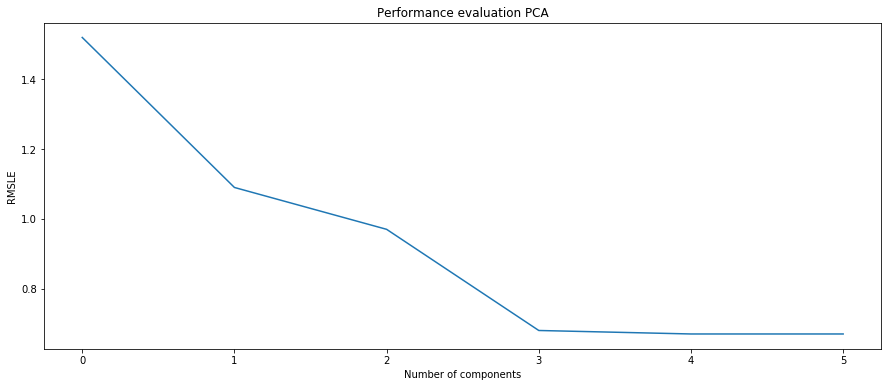

In [219]:
rfModel = RandomForestRegressor(n_estimators=100)
df_ = train_old_edit_std.copy()
listVals = []
bestAvg = 1000
nBest = 1000
countWorsening = 0
for i in range(1, 30):
    newVal = testModel(df = df_, n_splits = 10, model = rfModel, pca = True, n_components = i, returnVal = True)
    listVals.append(newVal)
    
    if newVal < bestAvg:
        bestAvg = avgVal
        nBest = i
    elif newVal > bestAvg:
        countWorsening += 1
        
    if (countWorsening > 5) or (i == len(df_.columns) - 3):
        break
        
    
f, axs = plt.subplots(1, 1, figsize=(15,6))
axs.plot(range(0, len(listVals)), listVals)
_ = axs.set(xlabel="Number of components", ylabel='RMSLE', title='Performance evaluation PCA')

In [218]:
len(df_.columns), i

(9, 5)

In [220]:
newVal = testModel(df = df_, n_splits = 10, model = rfModel, pca = True, n_components = 5, returnVal = True, predict_count = True)

RMSLE Value For Kf_i:  0.85, 0.89, 0.86, 0.94, 0.85, 0.78, 0.82, 0.85, 0.84, 0.9, Average RMSLE:  0.86


*'log_count' is still probably better than 'count as the predicted value*

##### B. Hyperparameter tuning with Bayesian optimisation and explore different models
    - run below methods

In [64]:
#### ---------------------------------- HELPER FUNCTION --------------------------------------------------------------------

def run_train_test_split(model):
    df = df_Bayes_opt.copy()
    X = df.drop(['log_count', 'count'], axis = 1).values
    y = df.drop(df.columns.difference(['log_count']), axis = 1).values
    n_splits = 3
    kf = KFold(n_splits, True, 1)
    rmsleScores = []

    for train_index, test_index in kf.split(X):
        trainX, testX = X[train_index], X[test_index]
        trainy, testy = y[train_index], y[test_index]
        mdl_ = clone(model)
        mdl_.fit(trainX,trainy)
        preds = mdl_.predict(testX)
        rmsle_ = rmsle(testy, preds)
        rmsleScores.append(rmsle_)
    avgRmsle = sum(rmsleScores) / len(rmsleScores)
    return avgRmsle

#### ---------------------------------- OPTIMISERS --------------------------------------------------------------------

def train_bayes_opt_rforest(max_depth, min_impurity_decrease, n_estimators):
    
    params_ = {
        'max_depth': int(max_depth),
        'min_impurity_decrease': float(min_impurity_decrease),
        'n_estimators': int(n_estimators)
    }
    
    mdl = RandomForestRegressor(**params_)
    avgRmsle = run_train_test_split(mdl)
    return -avgRmsle

## -----------------------------------------------------------------------------------------------------------------------

def train_bayes_opt_xgboost(max_depth, gamma, learning_rate, n_estimators):
    
    params = {       
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(n_estimators)
    }
    
    mdl = xgb.XGBRegressor(**params, silent = True)
    avgRmsle = run_train_test_split(mdl)
    return -avgRmsle

## -----------------------------------------------------------------------------------------------------------------------

def train_bayes_opt_lgbm(max_depth, gamma, learning_rate, n_estimators):
    
    params = {       
        'max_depth': int(max_depth),
        'gamma': gamma,
        'learning_rate':learning_rate,
        'n_estimators':int(n_estimators)
    }

    mdl = LGBMRegressor(**params)
    avgRmsle = run_train_test_split(mdl)
    return -avgRmsle

## -----------------------------------------------------------------------------------------------------------------------


def train_bayes_opt_gradboost(max_depth, min_impurity_decrease, learning_rate, n_estimators):
    
    params = {       
        'max_depth': int(max_depth),
        'min_impurity_decrease': min_impurity_decrease,
        'learning_rate':learning_rate,
        'n_estimators':int(n_estimators)
    }

    mdl = GradientBoostingRegressor(**params)
    avgRmsle = run_train_test_split(mdl)
    return -avgRmsle

def train_bayes_opt_ridge(alpha):
    
    params = {       
        'alpha': alpha,
    }

    mdl = Ridge(**params)
    avgRmsle = run_train_test_split(mdl)
    return -avgRmsle

def train_bayes_opt_lasso(alpha):
    
    params = {       
        'alpha': alpha,
    }

    mdl = Lasso(**params)
    avgRmsle = run_train_test_split(mdl)
    return -avgRmsle

i. Try Random Forest

In [46]:
bounds_ = {'n_estimators':(50, 250),
              'min_impurity_decrease':(0.0,0.01),
              'max_depth':(5,100)
             }

df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_rforest,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   | max_depth | min_im... | n_esti... |
-------------------------------------------------------------
|  1        | -0.1327   |  44.62    |  0.007203 |  50.02    |
|  2        | -0.1093   |  33.72    |  0.001468 |  68.47    |
|  3        | -0.1206   |  22.69    |  0.003456 |  129.4    |
|  4        | -0.124    |  56.19    |  0.004192 |  187.0    |
|  5        | -0.1359   |  24.42    |  0.008781 |  55.48    |
|  6        | -0.1238   |  68.69    |  0.004173 |  161.7    |
|  7        | -0.1126   |  18.34    |  0.001981 |  210.1    |
|  8        | -0.1189   |  96.98    |  0.003134 |  188.5    |
|  9        | -0.1353   |  88.26    |  0.008946 |  67.01    |
|  10       | -0.112    |  8.71     |  0.001698 |  225.6    |
|  11       | -0.1286   |  99.55    |  0.005485 |  249.7    |
|  12       | -0.1163   |  40.46    |  0.002599 |  250.0    |
|  13       | -0.1303   |  59.08    |  0.00606  |  98.32    |
|  14       | -0.1338   |  5.031    |  0.00472  |  96.69    |
|  15   

In [47]:
df_ = train_old_edit_std.copy()
# Use best feature combinations and trial 
rfModel = RandomForestRegressor(n_estimators = 166, min_impurity_decrease = 0.0, max_depth = 85)
newVal = testModel(df = df_, n_splits = 10, model = rfModel)

RMSLE Value For Kf_i:  0.36, 0.36, 0.35, 0.37, 0.37, 0.35, 0.35, 0.36, 0.36, 0.37, Average RMSLE:  0.359


In [324]:
bounds_ = {'n_estimators':(50, 1000),
              'learning_rate':(0.1,0.8),
              'max_depth':(1,10),
               'gamma':(0,1),
             }

df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_xgboost,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.1446   |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.1049   |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.09664  |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.1441   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.1085   |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.06788  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.1472   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.1441   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.09527  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.1452   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.1457   |  1.0      |  0.8      |  1.0      |  1e+03    |
|  12       | -0.1457   |  1.0      | 

In [340]:
df_ = train_old_edit_std.copy()
# Use best feature combinations and trial 
xgModel = xgb.XGBRegressor(gamma = 0.8007, learning_rate = 0.7778, max_depth = 4, n_estimators = 708, silent = True)
newVal = testModel(df = df_, n_splits = 10, model = xgModel)

RMSLE Value For Kf_i:  0.37, 0.39, 0.39, 0.39, 0.39, 0.36, 0.39, 0.38, 0.39, 0.4, Average RMSLE:  0.384


Try LGBM Regressor for comparison

In [335]:
bounds = {
        'gamma': (0,1),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_lgbm,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.144    |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.102    |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.0921   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.1438   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.09866  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.09405  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.1472   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.1439   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.09349  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.1438   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.08765  |  1.0      |  0.1      |  10.0     |  1e+03    |
|  12       | -0.03783  |  1.0      | 

In [67]:
df_ = train_old_edit_std.copy()
# Use best feature combinations and trial 
lgbmMod = LGBMRegressor(gamma = 0.9866, learning_rate = 0.7375, max_depth = 10, n_estimators = 791, silent = True)
newVal = testModel(df = df_, n_splits = 10, model = lgbmMod)

RMSLE Value For Kf_i:  0.35, 0.35, 0.35, 0.35, 0.38, 0.35, 0.35, 0.36, 0.36, 0.36, Average RMSLE:  0.356


**Best score so far.**

Use same parameters for XGBoost

In [342]:
df_ = train_old_edit_std.copy()
# Use best feature combinations and trial 
xgModel = xgb.XGBRegressor(gamma = 0.9866, learning_rate = 0.7375, max_depth = 10, n_estimators = 791, silent = True)
newVal = testModel(df = df_, n_splits = 10, model = xgModel)

RMSLE Value For Kf_i:  0.38, 0.38, 0.37, 0.37, 0.39, 0.37, 0.37, 0.35, 0.39, 0.39, Average RMSLE:  0.376


Try Gradient Boosting Regressor

In [48]:
bounds_ = {
        'min_impurity_decrease': (0.0,0.01),
        'max_depth': (1, 10),
        'learning_rate': (0.1, 0.8),
        'n_estimators':(50,1000),
        }
df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_gradboost,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   | learni... | max_depth | min_im... | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.09726  |  0.3919   |  7.483    |  1.144e-0 |  337.2    |
|  2        | -0.145    |  0.2027   |  1.831    |  0.001863 |  378.3    |
|  3        | -0.09316  |  0.3777   |  5.849    |  0.004192 |  701.0    |
|  4        | -0.09518  |  0.2431   |  8.903    |  0.000273 |  686.9    |
|  5        | -0.06479  |  0.3921   |  6.028    |  0.001404 |  238.2    |
|  6        | -0.1095   |  0.6605   |  9.714    |  0.003134 |  707.7    |
|  7        | -0.0754   |  0.7135   |  9.051    |  0.000850 |  87.1     |
|  8        | -0.09354  |  0.2189   |  8.903    |  0.000983 |  450.1    |
|  9        | -0.06868  |  0.7705   |  5.798    |  0.006919 |  349.7    |
|  10       | -0.07037  |  0.5806   |  8.512    |  0.000182 |  762.6    |
|  11       | -0.1445   |  0.1      |  1.0      |  0.01     |  1e+03    |
|  12       | -0.1439   |  0.8      | 

In [38]:
# Use best feature combinations and trial 
df_ = train_old_edit_std.copy()
gbModel = GradientBoostingRegressor(min_impurity_decrease = 0.005189, learning_rate = 0.7368, max_depth = 10, n_estimators = 417)
newVal = testModel(df = df_, n_splits = 10, model = gbModel)

RMSLE Value For Kf_i:  0.4, 0.41, 0.42, 0.41, 0.44, 0.41, 0.41, 0.42, 0.39, 0.43, Average RMSLE:  0.414


Compare with standard linear regression

In [330]:
lModel = LinearRegression()
df_ = train_old_edit_std.copy()
# Use best feature combinations and trial 
newVal = testModel(df = df_, n_splits = 10, model = rfModel)

RMSLE Value For Kf_i:  1.01, 1.02, 0.98, 1.04, 1.01, 0.98, 1.01, 0.99, 0.98, 1.0, Average RMSLE:  1.0


Compare with Ridge regression
    - Multicollinearity should however not be an issue because collinear features have been removed from this dataset

In [55]:
bounds_ = {
        'alpha': (0.0001,1000),
        }
df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_ridge,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.2356   |  417.0    |
|  2        | -0.2357   |  720.3    |
|  3        | -0.2355   |  0.1145   |
|  4        | -0.2356   |  302.3    |
|  5        | -0.2356   |  146.8    |
|  6        | -0.2356   |  92.34    |
|  7        | -0.2356   |  186.3    |
|  8        | -0.2356   |  345.6    |
|  9        | -0.2356   |  396.8    |
|  10       | -0.2356   |  538.8    |
|  11       | -0.2357   |  1e+03    |
|  12       | -0.2357   |  999.9    |
|  13       | -0.2357   |  999.9    |
|  14       | -0.2355   |  0.006021 |
|  15       | -0.2357   |  999.8    |
|  16       | -0.2355   |  0.06322  |
|  17       | -0.2355   |  0.6629   |
|  18       | -0.2357   |  999.9    |
|  19       | -0.2355   |  0.08496  |
|  20       | -0.2355   |  0.6504   |
|  21       | -0.2357   |  1e+03    |
|  22       | -0.2355   |  1.336    |
|  23       | -0.2357   |  998.3    |
|  24       | -0.2355   |  0.6088   |
|  25       

In [57]:
# Use best feature combinations and trial 
df_ = train_old_edit_std.copy()
gbModel = Ridge(alpha = 0.006021)
newVal = testModel(df = df_, n_splits = 10, model = gbModel)

RMSLE Value For Kf_i:  1.01, 1.02, 0.98, 1.04, 1.01, 0.98, 1.01, 0.99, 0.98, 1.0, Average RMSLE:  1.002


In [65]:
bounds_ = {
        'alpha': (0.0001,1000),
        }
df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_lasso,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=50)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -0.3156   |  417.0    |
|  2        | -0.3156   |  720.3    |
|  3        | -0.2367   |  0.1145   |
|  4        | -0.3156   |  302.3    |
|  5        | -0.3156   |  146.8    |
|  6        | -0.3156   |  92.34    |
|  7        | -0.3156   |  186.3    |
|  8        | -0.3156   |  345.6    |
|  9        | -0.3156   |  396.8    |
|  10       | -0.3156   |  538.8    |
|  11       | -0.3156   |  1e+03    |
|  12       | -0.3156   |  881.3    |
|  13       | -0.2357   |  0.007653 |
|  14       | -0.2356   |  0.00526  |
|  15       | -0.236    |  0.024    |
|  16       | -0.236    |  0.02523  |
|  17       | -0.2359   |  0.01646  |
|  18       | -0.2356   |  0.000400 |
|  19       | -0.2356   |  0.005134 |
|  20       | -0.2357   |  0.006251 |
|  21       | -0.2357   |  0.006312 |
|  22       | -0.2361   |  0.03426  |
|  23       | -0.2357   |  0.007485 |
|  24       | -0.2357   |  0.007089 |
|  25       

In [66]:
# Use best feature combinations and trial 
df_ = train_old_edit_std.copy()
gbModel = Lasso(alpha = 0.000105)
newVal = testModel(df = df_, n_splits = 10, model = gbModel)

RMSLE Value For Kf_i:  1.01, 1.02, 0.98, 1.04, 1.01, 0.98, 1.01, 0.99, 0.98, 1.0, Average RMSLE:  1.002


LGBM produced best results and was relatively quick:
        - Try exploring parameter space further and constraining to promising areas
        - extend number of iterations for optimiser
        - use grid search.. trade-off with time taken

In [344]:
bounds = {
        'gamma': (0.9, 1),
        'max_depth': (9, 11),
        'learning_rate': (0.7, 0.8),
        'n_estimators':(500,1000),
        }
df_Bayes_opt = train_old_edit_std.copy()

# Run Bayesian Optimizer:
optimizer = BayesianOptimization(f=train_bayes_opt_lgbm,  pbounds=bounds_, random_state=1)
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
|  1        | -0.144    |  0.417    |  0.6042   |  1.001    |  337.2    |
|  2        | -0.102    |  0.1468   |  0.1646   |  2.676    |  378.3    |
|  3        | -0.0921   |  0.3968   |  0.4772   |  4.773    |  701.0    |
|  4        | -0.1438   |  0.2045   |  0.7147   |  1.246    |  686.9    |
|  5        | -0.09866  |  0.4173   |  0.4911   |  2.263    |  238.2    |
|  6        | -0.09405  |  0.8007   |  0.7778   |  3.821    |  707.7    |
|  7        | -0.1472   |  0.8764   |  0.7262   |  1.765    |  87.1     |
|  8        | -0.1439   |  0.1698   |  0.7147   |  1.885    |  450.1    |
|  9        | -0.09349  |  0.9579   |  0.4732   |  7.227    |  349.7    |
|  10       | -0.1438   |  0.6865   |  0.6842   |  1.165    |  762.6    |
|  11       | -0.08765  |  1.0      |  0.1      |  10.0     |  1e+03    |
|  12       | -0.03783  |  1.0      | 

|  67       | -0.08761  |  0.0      |  0.1      |  10.0     |  331.2    |
|  68       | -0.1638   |  1.0      |  0.1      |  1.0      |  112.3    |
|  69       | -0.06997  |  1.0      |  0.8      |  10.0     |  369.2    |
|  70       | -0.03772  |  0.0      |  0.8      |  10.0     |  713.1    |
|  71       | -0.1447   |  1.0      |  0.1      |  1.0      |  972.2    |
|  72       | -0.1438   |  0.0      |  0.8      |  1.0      |  791.4    |
|  73       | -0.1439   |  1.0      |  0.8      |  1.0      |  474.7    |
|  74       | -0.1438   |  0.0      |  0.8      |  1.0      |  655.9    |
|  75       | -0.1445   |  1.0      |  0.8      |  1.0      |  214.6    |
|  76       | -0.08792  |  0.0      |  0.1      |  10.0     |  295.8    |
|  77       | -0.0904   |  0.0      |  0.1      |  10.0     |  142.8    |
|  78       | -0.08695  |  0.0      |  0.1      |  10.0     |  655.6    |
|  79       | -0.1448   |  0.0      |  0.1      |  1.0      |  916.8    |
|  80       | -0.0378   |  1.0      | 

Try Grid Search

In [355]:
df_ = train_old_edit_std.copy()

grid_param = {
    'n_estimators': [500, 600, 700, 800, 900, 1000],
    'learning_rate': [0.7, 0.72, 0.74, 0.76, 0.78, 0.8],
    'gamma': [0.95, 0.96, 0.97, 0.98, 0.99, 1],
    'max_depth': [9, 10, 11],
}


rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

gd_sr = GridSearchCV(estimator= LGBMRegressor(),
                     param_grid=grid_param,
                     scoring=rmsle_scorer,
                     cv=5,
                     n_jobs=-1)

X = df_.drop(['log_count', 'count'], axis = 1).values
y = df_.drop(df_.columns.difference(['log_count']), axis = 1).values

gd_sr.fit(X, y)
best_params = gd_sr.best_params_
print(gd_sr.best_params_)

{'gamma': 0.95, 'learning_rate': 0.78, 'max_depth': 10, 'n_estimators': 500}


Employ best Grid Search Parameters

In [356]:
df_ = train_old_edit_std.copy()
# Use best feature combinations and trial 
lgbmMod = LGBMRegressor(gamma = 0.95, learning_rate = 0.78, max_depth = 10, n_estimators = 500, silent = True)
newVal = testModel(df = df_, n_splits = 10, model = lgbmMod)

RMSLE Value For Kf_i:  0.36, 0.37, 0.35, 0.37, 0.38, 0.35, 0.36, 0.37, 0.35, 0.36, Average RMSLE:  0.361


**Conclusion** 
- LGBM regressor produced best results:
- *Perhaps with more time invested the results could be better. Bayesian optimisation appears to have been most productive* 
    - lgbmMod = LGBMRegressor(gamma = 0.9866, learning_rate = 0.7375, max_depth = 10, n_estimators = 791, silent = True)
        

## -----------------------------------------------------------------------------------------------------------------------------------